In [1]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
from nf_slam.space_hashing_mapping.mapping import LearningConfig, OptimizerConfig, ScanData,\
    init_map_model, BuildMapState
from nf_slam.plotting_utils import show_points, plot_nf_with_scans, plot_optimization_result,\
    plot_reconstructed_result, plot_model_heatmap_cnf, get_points
from nf_slam.tracking.tracking import OptimizePositionConfig, PositionOptimizer, \
    OptimizePositionState
from nf_slam.position_2d import Position2D
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import tqdm
import matplotlib.animation
import io
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 150
import flax.linen as nn
import dataclasses
from nf_slam.space_hashing_mapping.map_model import MapModel
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
import optax
import functools
import jax
import jax_dataclasses as jdc
from dataclasses import dataclass
from nf_slam.space_hashing_mapping.jax_math import calculate_layer_embeddings
from nf_slam.space_hashing_mapping.mapping import transform_points, calculate_points
from flax.optim.adam import Adam
from flax.optim import OptimizerState
from nf_slam.cnf.mapping import MapModelConfig, MapBuildingConfig, RectangleBoundary, MapBuilder
from nf_slam.cnf.tracking import BatchPositionOptimizer, BatchPositionOptimizerConfig, ScanDataBatch, TrackingConfig
import jax.random

ROS is not sourced. To enable ROS features, please source it


In [2]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [3]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
# datafile = "/home/mikhail/Downloads/intel.log"
laser_data_list = dataset_loader.load(datafile)

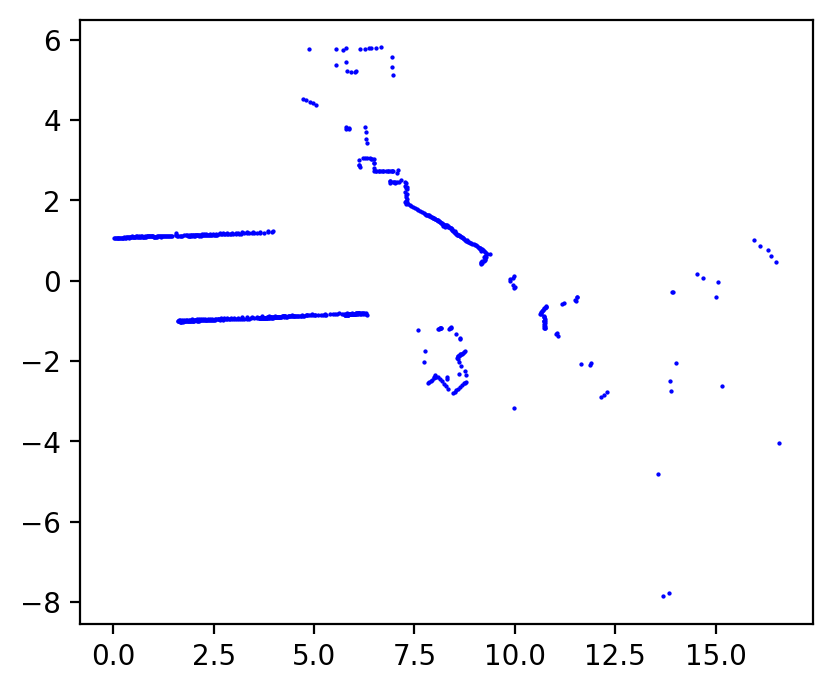

In [4]:
plt.figure(dpi=200)
show_points(laser_data_list[10:20:2], c="blue");

# Map building

In [5]:
learning_index = 17
points = get_points(laser_data_list[learning_index:learning_index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)


map_model_config = MapModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    F=4,
    L=16,
    T=4096,
    min_log_resolution=-0.5,
    max_log_resolution=2.,
)

map_building_config = MapBuildingConfig(
    sampling_depth_delta=3.,
    sampling_depth_count=200,
    point_loss_weight=1.,
    classification_loss_weight=1.,
    random_point_boundary=RectangleBoundary(*bounds),
    random_point_loss_weight=100.,
    random_point_count=100,
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=0.5e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-5,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=3e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)

mlp_model = MLPModel()
map_builder = MapBuilder(learning_config, map_building_config, map_model_config, mlp_model)

learning_index = 17
laser_data = laser_data_list[learning_index]
map_position = jnp.array(laser_data.odometry_position.as_vec())
map_model = map_builder.build_map(laser_data, map_position)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.31it/s]


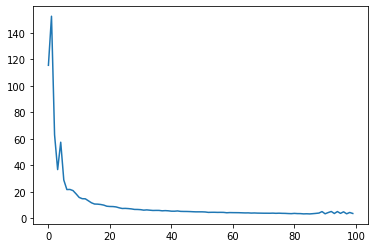

In [6]:
plt.plot(map_builder.loss_history)

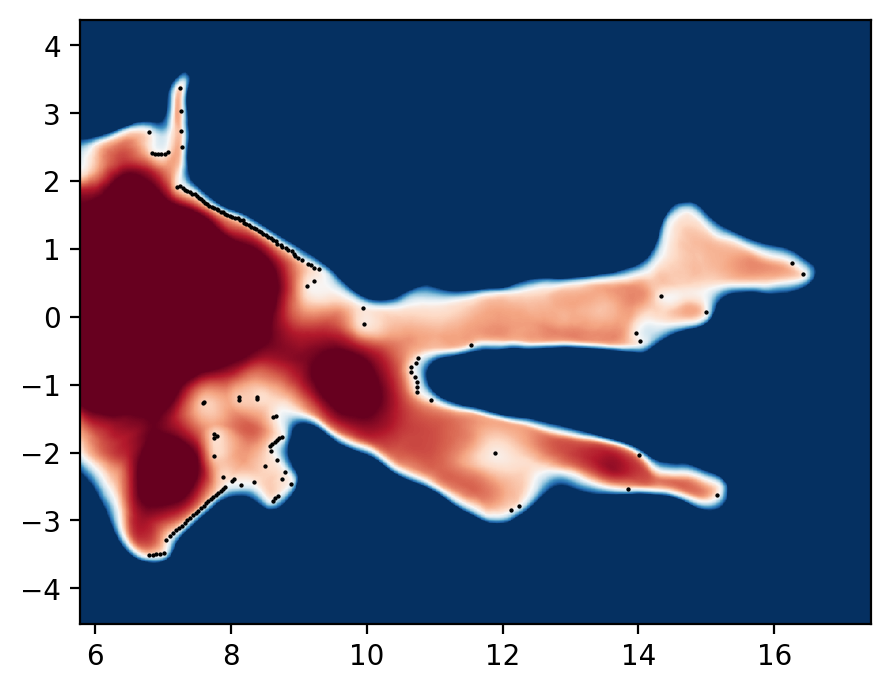

In [7]:
plt.figure(dpi=200)
value = 10
points = show_points(laser_data_list[learning_index:learning_index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap_cnf(map_model, bounds, mlp_model, grid_shape=(1000, 1000), vmin=-value, vmax=value)
show_points(laser_data_list[learning_index:learning_index + 1], c="black");

# Batch optimization

In [8]:
def get_points_from_laser_data_list(data_list):
    all_points = []
    for laser_data in data_list:
        all_points.append(laser_data.as_points_in_odometry_frame())
    points = np.concatenate(all_points, axis=0)
    return points

def plot_scans_at_positions(data_list, positions, c="green"):
    all_points = []
    for position, laser_data in zip(positions, data_list):
        all_points.append(position.apply(laser_data.as_points()))
    points = np.concatenate(all_points, axis=0)
    plt.scatter(points[:, 0], points[:, 1], s=0.5, c=c)
    return points

In [217]:
def calculate_init_positions(data_list, noise=0):
    result = jnp.array([x.odometry_position.as_vec() for x in data_list]).reshape(-1)
    delta = jax.random.normal(jax.random.PRNGKey(0), result.shape) * noise
    delta = jnp.concatenate([jnp.zeros(3), delta[3:]], axis=0)
    return result + delta


In [177]:
position_optimization_config = BatchPositionOptimizerConfig(
    learning_rate=0.9,
    iterations=100,
    init_hessian=jnp.diag(jnp.array([200, 200, 200])),
    maximal_clip_norm=100,
    beta1=0.5,
    beta2=0.3,
    hessian_adder=jnp.diag(jnp.array([200, 200, 200])) * 0.1,
    tracking_config=TrackingConfig(huber_scale=0.3),
    batch_size=2
)
map_model_config = MapModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    F=4,
    L=16,
    T=4096,
    min_log_resolution=-1.5,
    max_log_resolution=2.,
)

map_building_config = MapBuildingConfig(
    sampling_depth_delta=3.,
    sampling_depth_count=200,
    point_loss_weight=1.,
    classification_loss_weight=1.,
    random_point_boundary=RectangleBoundary(*bounds),
    random_point_loss_weight=100.,
    random_point_count=100,
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=0.5e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-5,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=3e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)

In [218]:
iterations = 100
np.random.seed(200)
# local_data_list = laser_data_list[0:5:1]
local_data_list = laser_data_list[13:13 + 10:1]
batch_size = len(local_data_list)
position_optimization_config.batch_size = batch_size

points = get_points(local_data_list)
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
map_building_config = MapBuildingConfig(
    sampling_depth_delta=3.,
    sampling_depth_count=200,
    point_loss_weight=10,
    classification_loss_weight=1.,
    random_point_boundary=RectangleBoundary(*bounds),
    random_point_loss_weight=100.,
    random_point_count=100,
)
np.random.seed(200)
optimized_positions = calculate_init_positions(local_data_list, noise=0.05)
init_positions = [Position2D.from_vec(np.array(x)) for x in optimized_positions.reshape(-1, 3)]
map_model = init_map_model(mlp_model, map_model_config)

scan_data_batch = ScanDataBatch.from_data_list(local_data_list, 100)
map_builder = MapBuilder(learning_config, map_building_config, map_model_config, mlp_model)
map_builder.setup(map_model)
position_optimizer = BatchPositionOptimizer(position_optimization_config, mlp_model)
position_optimizer.setup()

postion_optimizer_states = []
position_history = []
for i in tqdm.tqdm(range(1000)):
#     np.random.seed(200)
    scan_data_batch = ScanDataBatch.from_data_list(local_data_list, 100)
    if i <= 1000:
        mapping_positions = optimized_positions.reshape(-1, 3)[scan_data_batch.indices]
        new_map_model = map_builder.step(map_model, mapping_positions, scan_data_batch.scan_data)
    if i > 30:
        preivous_optimized_positions = optimized_positions
        previous_mean = preivous_optimized_positions.reshape(-1, 3).mean(axis=0)
        optimized_positions = position_optimizer.step(optimized_positions, map_model, scan_data_batch)
        postion_optimizer_states.append(position_optimizer.state)
        mean = optimized_positions.reshape(-1, 3).mean(axis=0)
        mean_delta = previous_mean - mean
        optimized_positions = (optimized_positions.reshape(-1, 3) + mean_delta[None]).reshape(-1)
#         optimized_positions = jnp.concatenate([preivous_optimized_positions[:3], optimized_positions[3:]], axis=0)
        position_history.append(optimized_positions)
    map_model = new_map_model
reconstructed_positions = [Position2D.from_vec(np.array(x)) for x in optimized_positions.reshape(-1, 3)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:51<00:00,  4.32it/s]


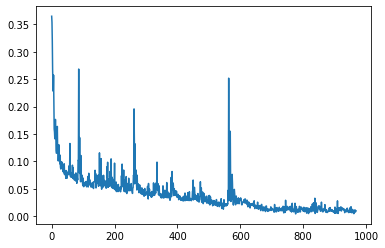

In [219]:
plt.plot(position_optimizer.loss_history)

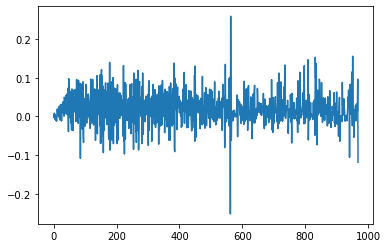

In [220]:
plt.plot([x.previous_grad[2] for x in postion_optimizer_states])

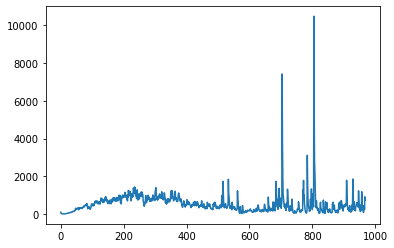

In [221]:
plt.plot([x.previous_hessian[5, 5] for x in postion_optimizer_states])

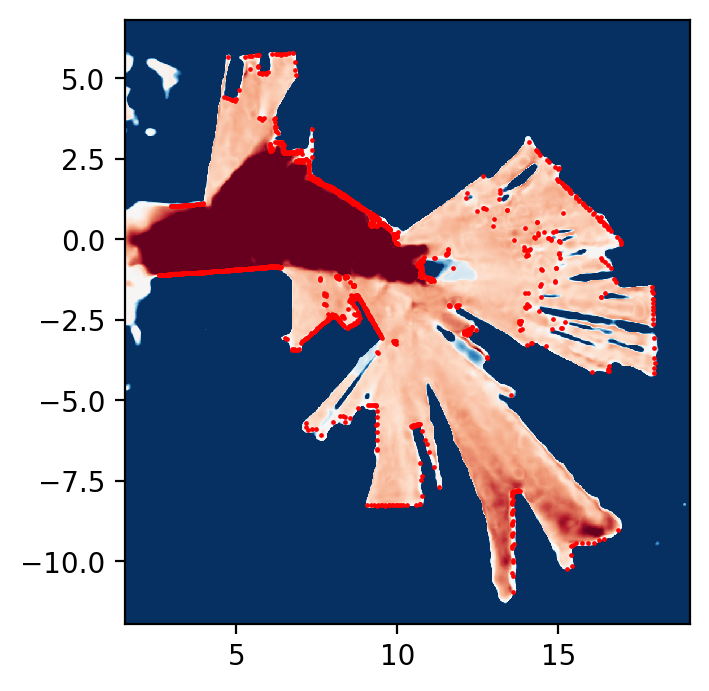

In [223]:
plt.figure(dpi=200)
value=10
plot_model_heatmap_cnf(map_model, bounds, mlp_model, grid_shape=(1000, 1000), vmin=-value, vmax=value)
points = get_points(local_data_list)
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)

plot_scans_at_positions(local_data_list, reconstructed_positions, c="red")
# plot_scans_at_positions(local_data_list, init_positions, c="yellow")
# show_points(local_data_list, c="black");
plt.gca().set_aspect('equal')